In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 


In [2]:
import os
from os.path import join
import pandas as pd
from src.config import RESULTS, FIGURES_DIR, ROOT_DIR
from src.calculate_AF_by_cell import calculate_af
#ref_fa = "/data2/genome/human_GRCh38/cellranger/refdata-cellranger-GRCh38-3.0.0/fasta/genome.fa"
ref_fa="/data2/mito_lineage/BWA-Primers-MT/MT_genome/MT.fasta"
maxBP = 16571


import numpy as np

Project Directory: /data2/mito_lineage


In [3]:
from matplotlib_venn import venn2

import seaborn as sns
import matplotlib.pyplot as plt

from mplh import cluster_help

fig_utils from mplh
here


In [4]:
os.chdir(ROOT_DIR)

## Files setup

In [5]:
indir=join(RESULTS,"mttrace")
mapq = "mapq_30"
num_reads = 200
flt3 = "CD34_Flt3L_mt_PolydT"
wt = "CD34_mt_PolydT"



flt3_indir = join(indir, flt3,"mapq_30")
wt_indir = join(indir, wt,"mapq_30")

# sc_coverage_flt3_f = join(flt3_indir,"scPileup_concat_200",flt3+"_200_all.coverage.txt.gz")
# sc_coverage_wt_f = join(wt_indir,"scPileup_concat_200",wt + "_200_all.coverage.txt.gz")

coverage_flt3_dir = join(flt3_indir,flt3+"_scPileup_200")
coverage_wt_dir = join(wt_indir,wt+"_scPileup_200")

concat_flt3_dir = join(flt3_indir,"scPileup_concat_200")
concat_wt_dir = join(wt_indir,"scPileup_concat_200")

In [6]:
min_cells=10
min_reads=10
topN=500
min_het_cells=10
het_thresh=0.1

In [7]:
dirname = f"minC{min_cells}_minR{min_reads}_topN{topN}_hetC{min_het_cells}_hetT{het_thresh}"
outdir = join(indir, "lineage_trace/CD34_mt_polydT/report", dirname)
if not os.path.exists(outdir):
    os.makedirs(outdir)
outdir

'/data2/mito_lineage/data/processed/mttrace/lineage_trace/CD34_mt_polydT/report/minC10_minR10_topN500_hetC10_hetT0.1'

### Get CD34 with and without Flt3L, first using polydT+mt
### Create allele frequency matrix for both, but add metadata for each cell about which experiment it came from
### Cluster and look

### Additional requirements is to remove poor-quality variants of BQ- see if Erick has the code of the mixture model

In [8]:
print(ref_fa)
print(maxBP)
print(coverage_wt_dir)
print(concat_wt_dir)

/data2/mito_lineage/BWA-Primers-MT/MT_genome/MT.fasta
16571
/data2/mito_lineage/data/processed/mttrace/CD34_mt_PolydT/mapq_30/CD34_mt_PolydT_scPileup_200
/data2/mito_lineage/data/processed/mttrace/CD34_mt_PolydT/mapq_30/scPileup_concat_200


In [9]:
wt_AF_by_cell, wt_BQ_by_cell, wt_af, wt_bq_df, wt_nt_df = calculate_af(coverage_wt_dir, concat_wt_dir, ref_fasta=ref_fa,AF_F=None, maxBP=maxBP, topN=topN, min_cells=min_cells, min_reads=min_reads,
                                                                      min_het_cells=min_het_cells, het_thresh=het_thresh)

no alt count 5331
Number of positions to keep : 1595
Number of cells to keep : 500
Positions that pass het filter: 65


In [10]:
print(f"Number of positions with heteroplasmy fraction above 0: {(wt_AF_by_cell>0).any(axis=0).sum()}")

Number of positions with heteroplasmy fraction above 0: 65


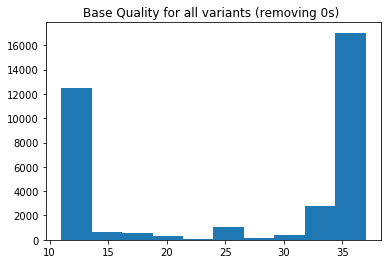

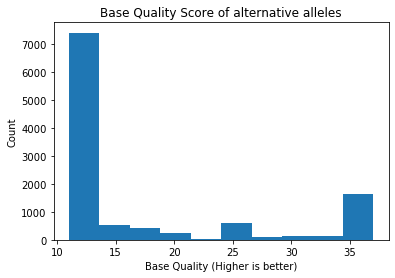

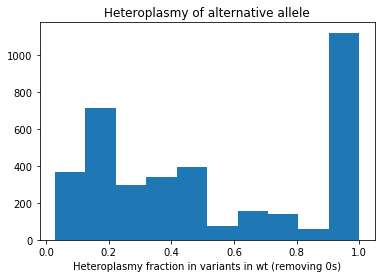

In [11]:
%matplotlib inline
f = plt.figure()
bq_vals = wt_bq_df.values.flatten()
plt.hist(bq_vals[bq_vals>0])
plt.title("Base Quality for all variants (removing 0s) ")
plt.savefig(join(outdir, "wt_base_quality.png"))

plt.figure()
plt.hist(wt_af["Alternative BQ"])
plt.title("Base Quality Score of alternative alleles")
plt.xlabel("Base Quality (Higher is better)")
plt.ylabel("Count")
plt.savefig(join(outdir, "wt_base_quality_altAllele.png"))


f = plt.figure()
af_vals = wt_AF_by_cell.values.flatten()
plt.hist(af_vals[af_vals>0])
plt.title("Heteroplasmy of alternative allele")
plt.xlabel("Heteroplasmy fraction in variants in wt (removing 0s)")
plt.savefig(join(outdir, "wt_heteroplasmy_values.png"))


# flt3

In [12]:
flt3_AF_by_cell, flt3_BQ_by_cell, flt3_af, flt3_bq_df, flt3_nt_df = calculate_af(coverage_flt3_dir, concat_flt3_dir, ref_fasta=ref_fa,AF_F=None, maxBP=maxBP, topN=topN, 
                                                                                 min_cells=min_cells, min_reads=min_reads,
                                                                                min_het_cells=min_het_cells, het_thresh=het_thresh)

no alt count 2142
Number of positions to keep : 3596
Number of cells to keep : 500
Positions that pass het filter: 194


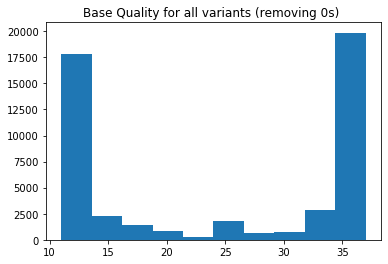

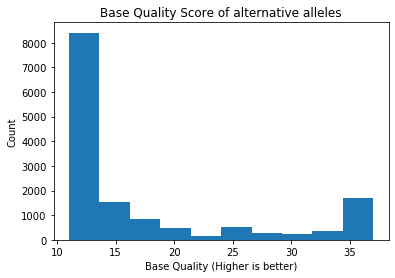

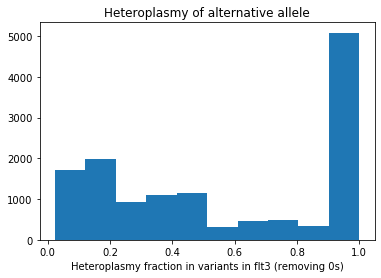

In [13]:
%matplotlib inline
f = plt.figure()
bq_vals = flt3_bq_df.values.flatten()
plt.hist(bq_vals[bq_vals>0])
plt.title("Base Quality for all variants (removing 0s) ")
plt.savefig(join(outdir, "flt3_base_quality.png"))

plt.figure()
plt.hist(flt3_af["Alternative BQ"])
plt.title("Base Quality Score of alternative alleles")
plt.xlabel("Base Quality (Higher is better)")
plt.ylabel("Count")
plt.savefig(join(outdir, "flt3_base_quality_altAllele.png"))


f = plt.figure()
af_vals = flt3_AF_by_cell.values.flatten()
plt.hist(af_vals[af_vals>0])
plt.title("Heteroplasmy of alternative allele")
plt.xlabel("Heteroplasmy fraction in variants in flt3 (removing 0s)")
plt.savefig(join(outdir, "flt3_heteroplasmy_values.png"))


## Merge the two 

In [14]:
flt3_AF_by_cell.index = flt3_AF_by_cell.index + "_flt3"
wt_AF_by_cell.index = wt_AF_by_cell.index + "_wt"


In [43]:
wt_AF_by_cell.columns = wt_AF_by_cell.columns.astype(str) 
flt3_AF_by_cell.columns = flt3_AF_by_cell.columns.astype(str)

all_cells = pd.concat((wt_AF_by_cell,flt3_AF_by_cell) ,axis=0)
print(len(set(wt_AF_by_cell.columns.values).union(set(flt3_AF_by_cell.columns.values))))
print(all_cells.shape)


In [16]:
all_cells_var_overlap = pd.concat((wt_AF_by_cell,flt3_AF_by_cell) ,axis=0, join='inner')
overlap_variants = all_cells_var_overlap.columns.values
all_cells_var_overlap


,663G,709A,2053A,2108C,2109T,2110G,2111T,2112T,2113C,2157A,...,9548A,9608C,9629T,9631A,9632T,9634G,9636T,9637A,10524C,14766T
GCGACCAAGGTGCACA-1_wt,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.666667,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0
CGTCTACGTGTGGCTC-1_wt,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0
GCGGGTTCAACAACCT-1_wt,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.25,0.0,0.0,0.0,0.0,0.0,0.0,1.0
ACCGTAATCGGCGCTA-1_wt,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0
GGGACCTTCCAGTAGT-1_wt,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TATCTCACATTAGGCT-1_flt3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AGCATACCATTACCTT-1_flt3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.900000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0
ATCACGACACTATCTT-1_flt3,0.000000,0.0,0.0,0.4,0.4,0.4,0.4,0.5,0.5,0.0,...,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CCGTACTAGCGTCAAG-1_flt3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.166667,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


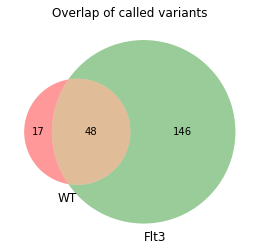

In [17]:
%matplotlib inline
venn2([set(wt_AF_by_cell.columns.values),set(flt3_AF_by_cell.columns.values)],set_labels=["WT","Flt3"])
plt.title("Overlap of called variants")
plt.savefig(join(outdir,"overlap_variants_with_without_ligand.png"))

## Plot the lineage tracing 

### With only the overlapping variants

In [18]:
all_cells_var_overlap = all_cells_var_overlap.drop((all_cells_var_overlap==0).all(axis=0).where(lambda x: x==True).dropna().index,axis=1)

all_cells_var_overlap = all_cells_var_overlap.drop((all_cells_var_overlap==0).all(axis=1).where(lambda x: x==True).dropna().index,axis=0)

In [19]:

row_meta = pd.concat((pd.DataFrame(index=flt3_AF_by_cell.index, data={"Sample":["Flt3"]*flt3_AF_by_cell.index.shape[0]}),
           pd.DataFrame(index= wt_AF_by_cell.index, data={"Sample":["wt"]*wt_AF_by_cell.index.shape[0]})))
row_meta = row_meta.loc[all_cells_var_overlap.index]
row_meta

,Sample
GCGACCAAGGTGCACA-1_wt,wt
CGTCTACGTGTGGCTC-1_wt,wt
GCGGGTTCAACAACCT-1_wt,wt
ACCGTAATCGGCGCTA-1_wt,wt
GGGACCTTCCAGTAGT-1_wt,wt
...,...
TATCTCACATTAGGCT-1_flt3,Flt3
AGCATACCATTACCTT-1_flt3,Flt3
ATCACGACACTATCTT-1_flt3,Flt3
CCGTACTAGCGTCAAG-1_flt3,Flt3


cmap None


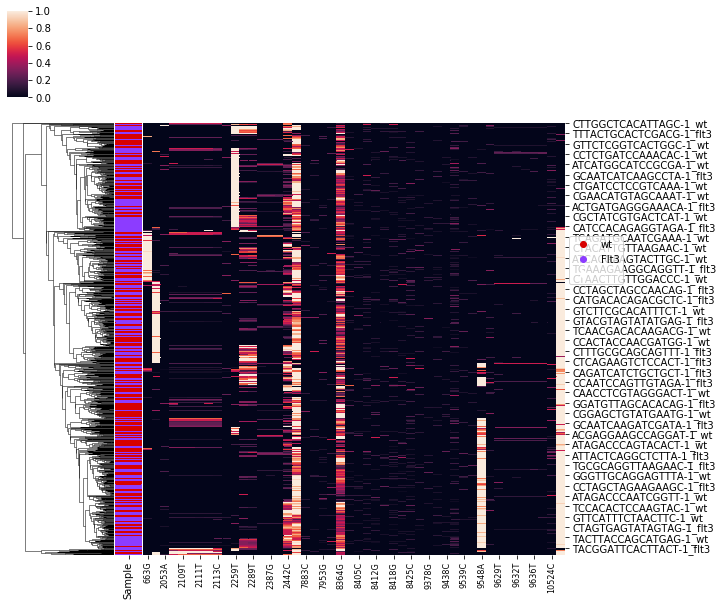

In [20]:
%matplotlib inline
cluster_help.plot_cluster(df=all_cells_var_overlap, row_meta=row_meta, col_meta=None,
                 fsave=None, to_z=False, to_col_clust=False,
                 to_row_clust=True, name=None, col_names=True,
                 row_names=True, to_legend=True, method="average", white_name=None)
plt.savefig(join(outdir,"lineage_OnlyoverlapVariants.png"))

## Plot number of overlapping positions from Flt3 and without

### With all variants

In [48]:
from mplh.fig_utils import helper_save

cmap None


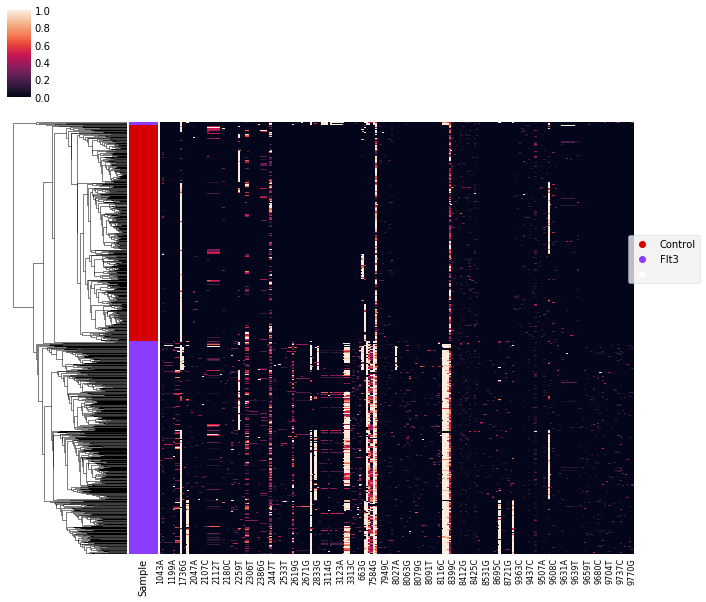

In [49]:
all_cells = all_cells.fillna(0)
all_cells = all_cells.drop((all_cells==0).all(axis=0).where(lambda x: x==True).dropna().index,axis=1)

all_cells = all_cells.drop((all_cells==0).all(axis=1).where(lambda x: x==True).dropna().index,axis=0)

# row_meta = pd.concat((pd.DataFrame(index=flt3_cell, data={"Sample":["Flt3"]*flt3_cell.shape[0]}),
#            pd.DataFrame(index=wt_cell, data={"Sample":["wt"]*wt_cell.shape[0]})))
# row_meta = row_meta.loc[all_cells.index]

row_meta = pd.concat((pd.DataFrame(index=flt3_AF_by_cell.index, data={"Sample":["Flt3"]*flt3_AF_by_cell.index.shape[0]}),
           pd.DataFrame(index= wt_AF_by_cell.index, data={"Sample":["Control"]*wt_AF_by_cell.index.shape[0]})))
row_meta = row_meta.loc[all_cells.index]
row_meta


g = cluster_help.plot_cluster(df=all_cells, row_meta=row_meta, col_meta=None,
                 fsave=None, to_z=False, to_col_clust=False,
                 to_row_clust=True, name=None, col_names=True,
                 row_names=False, to_legend=True, method="average", white_name=None)
helper_save(join(outdir,"lineage_AllVariants.png"))
#plt.savefig(join(outdir,"lineage_AllVariants.png"))

In [30]:
all_cells


,663G,709A,2047A,2053A,2108C,2109T,2110G,2111T,2112T,2113C,...,9734C,9736C,9737C,9744T,9754T,9768C,9769G,9770G,10524C,14766T
AAACCTGAGCAATATG-1_wt,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGCATACTACG-1_flt3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGCATCACCCT-1_flt3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0
AAACGGGCATCCTAGA-1_wt,0.0,0.0,0.0,0.0,0.5,0.5,0.500000,0.500000,0.500000,0.500000,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGGGGTCACCCAG-1_wt,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCGCTCGCCATAA-1_wt,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGCGCTCTGCAGTA-1_wt,0.0,1.0,0.0,0.0,1.0,1.0,0.333333,0.333333,0.333333,0.333333,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGGTTTCAGTTGAC-1_wt,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTCACACCATCCT-1_flt3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,1.0


## Scatter the average AF in both samples for each position 


[  663   709  2047  2053  2108  2109  2110  2111  2112  2113  2157  2259
  2285  2289  2386  2387  2388  2442  7585  7879  7883  7947  7949  7953
  7964  8364  8399  8401  8402  8405  8411  8412  8413  8418  8419  8422
  8425  8426  9355  9359  9363  9374  9378  9420  9436  9437  9438  9449
  9466  9485  9507  9539  9542  9548  9608  9621  9629  9631  9632  9634
  9636  9637  9645 10524 14766   663   709   750   930  1043  1193  1194
  1197  1199  1255  1314  1315  1736  1749  1888  1967  1983  2053  2091
  2096  2101  2107  2108  2109  2110  2111  2112  2113  2120  2157  2167
  2180  2181  2191  2192  2193  2259  2265  2274  2285  2289  2306  2307
  2308  2310  2333  2386  2387  2388  2403  2442  2447  2448  2450  2470
  2532  2533  2535  2611  2616  2617  2619  2662  2666  2669  2670  2671
  2672  2706  2792  2818  2833  2910  3109  3110  3113  3114  3115  3117
  3118  3121  3123  3126  3173  3176  3178  3313  3319  3320  3727  3728
  7582  7583  7584  7585  7883  7949  7951  7953  7

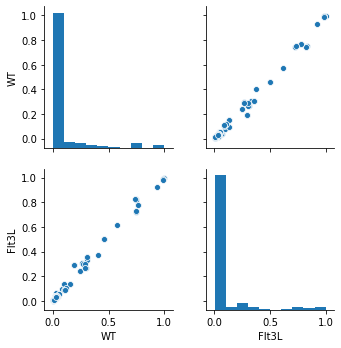

In [22]:
#pd.concat((wt_af, flt3_af))
import numpy as np
overlap_inds = np.array(list(map(lambda x: int(x[:-1]), all_cells.columns)))
print(overlap_inds)
merged_af = pd.DataFrame({"WT":wt_af.loc[overlap_inds,"AF"], "Flt3L":flt3_af.loc[overlap_inds, "AF"]})
merged_af = merged_af.fillna(0)
sns.pairplot(merged_af)
plt.savefig(join(outdir, "heteroplasmy_across_samples"))

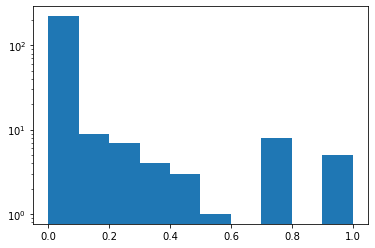

In [23]:
plt.hist((merged_af['WT'].astype(float)))
plt.yscale('log')

## Just using CD34 with no Flt3L

### Here we compare the rest of sequencing techniques done and see if we see the same variants, this ensuring the differences are consistent across the techniques and not technical noise.

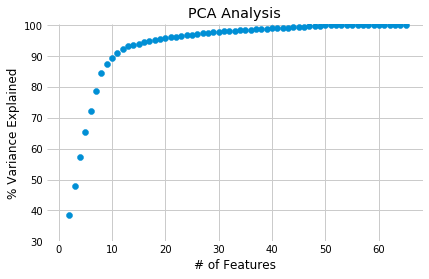

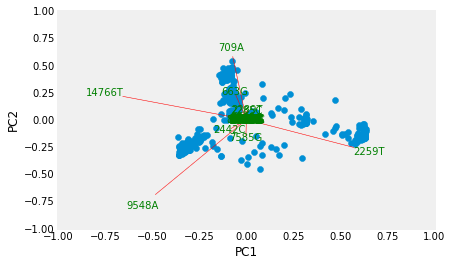

(                       2259T  2047A  2388G  2289T  2285C     7585G      663G  \
 GCGACCAAGGTGCACA-1_wt    0.0    0.0    0.0    0.0    0.0  1.000000  0.666667   
 CGTCTACGTGTGGCTC-1_wt    0.0    0.0    0.0    0.0    0.0  1.000000  0.000000   
 GCGGGTTCAACAACCT-1_wt    0.0    0.0    0.0    0.0    0.0  0.333333  0.000000   
 ACCGTAATCGGCGCTA-1_wt    0.0    0.0    0.0    0.0    0.0  0.857143  0.000000   
 GGGACCTTCCAGTAGT-1_wt    0.0    0.0    0.0    0.0    0.0  0.833333  0.000000   
 ...                      ...    ...    ...    ...    ...       ...       ...   
 CAACTAGCATTGTGCA-1_wt    1.0    1.0    0.0    0.0    0.0  0.000000  0.000000   
 CTCATTATCCTACAGA-1_wt    1.0    0.0    0.0    0.0    0.0  1.000000  0.000000   
 TAAGTGCCACTGTTAG-1_wt    1.0    0.0    0.0    0.0    0.0  0.500000  0.000000   
 ATCACGAAGTACTTGC-1_wt    0.0    0.0    0.0    0.5    0.5  1.000000  1.000000   
 TTGTAGGAGGCGATAC-1_wt    0.0    0.0    0.0    0.0    0.0  0.000000  0.000000   
 
                        70

<Figure size 432x288 with 0 Axes>

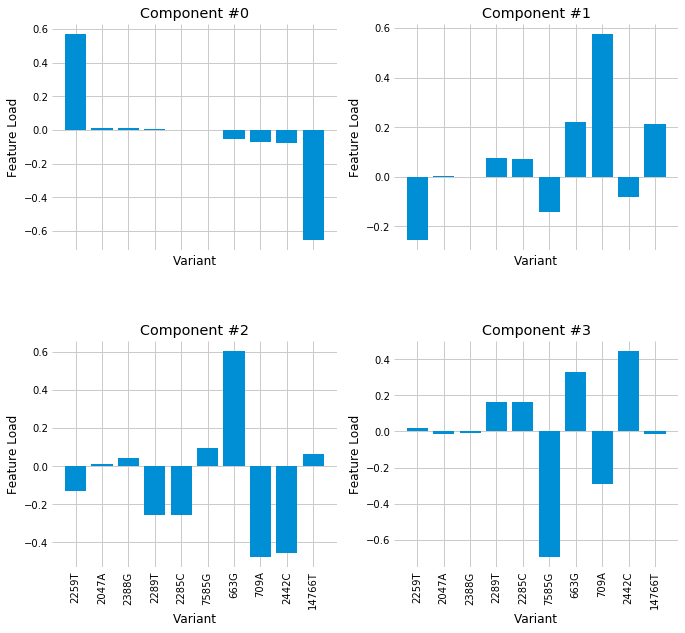

In [24]:
from src.utils import construct_pca
%matplotlib inline
construct_pca(wt_AF_by_cell.copy(), save_f=join(outdir, "pca"))

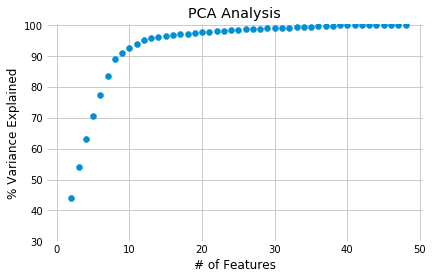

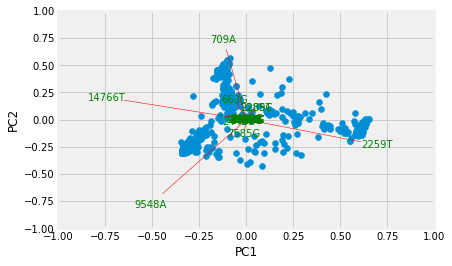

(                         2259T  2285C  2289T     2442C      663G  709A  \
 GCGACCAAGGTGCACA-1_wt      0.0    0.0    0.0  0.142857  0.666667   0.0   
 CGTCTACGTGTGGCTC-1_wt      0.0    0.0    0.0  0.500000  0.000000   0.0   
 GCGGGTTCAACAACCT-1_wt      0.0    0.0    0.0  1.000000  0.000000   1.0   
 ACCGTAATCGGCGCTA-1_wt      0.0    0.0    0.0  0.000000  0.000000   0.0   
 GGGACCTTCCAGTAGT-1_wt      0.0    0.0    0.0  0.200000  0.000000   0.0   
 ...                        ...    ...    ...       ...       ...   ...   
 TATCTCACATTAGGCT-1_flt3    1.0    0.5    0.5  0.250000  0.000000   0.0   
 AGCATACCATTACCTT-1_flt3    0.0    0.0    0.0  0.333333  0.000000   0.0   
 ATCACGACACTATCTT-1_flt3    1.0    0.5    0.5  0.600000  0.000000   0.0   
 CCGTACTAGCGTCAAG-1_flt3    1.0    0.0    0.0  0.000000  0.000000   0.0   
 CTCACACAGACACGAC-1_flt3    0.0    0.0    0.0  0.285714  0.000000   0.0   
 
                             9548A  14766T  
 GCGACCAAGGTGCACA-1_wt    0.666667     1.0  
 CGTCTAC

<Figure size 432x288 with 0 Axes>

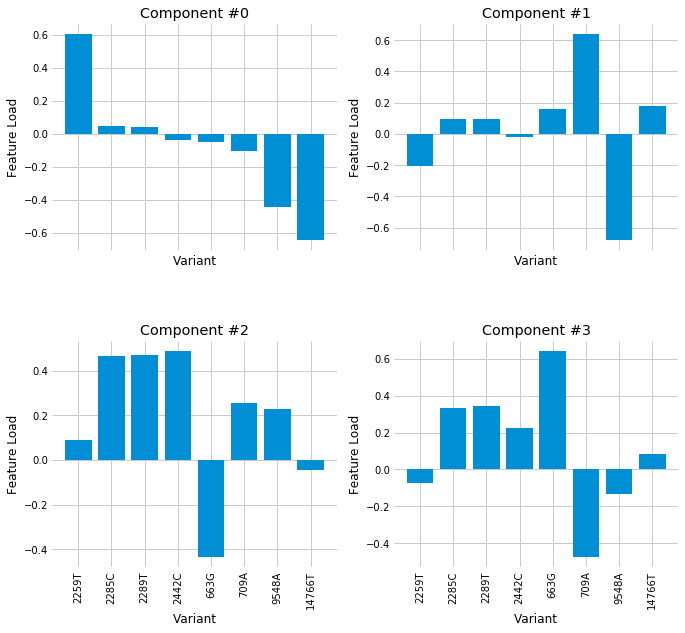

In [25]:
from src.utils import construct_pca
%matplotlib inline
construct_pca(all_cells_var_overlap.copy(), save_f=join(outdir, "pca"))

## Het by value

## Clustering

In [26]:
wt_AF_by_cell

,663G,709A,2047A,2053A,2108C,2109T,2110G,2111T,2112T,2113C,...,9621T,9629T,9631A,9632T,9634G,9636T,9637A,9645T,10524C,14766T
GCGACCAAGGTGCACA-1_wt,0.666667,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,1.0
CGTCTACGTGTGGCTC-1_wt,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,1.0
GCGGGTTCAACAACCT-1_wt,0.000000,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,1.0
ACCGTAATCGGCGCTA-1_wt,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,1.0
GGGACCTTCCAGTAGT-1_wt,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CAACTAGCATTGTGCA-1_wt,0.000000,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0
CTCATTATCCTACAGA-1_wt,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0
TAAGTGCCACTGTTAG-1_wt,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.00,0.0,0.0
ATCACGAAGTACTTGC-1_wt,1.000000,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,1.0


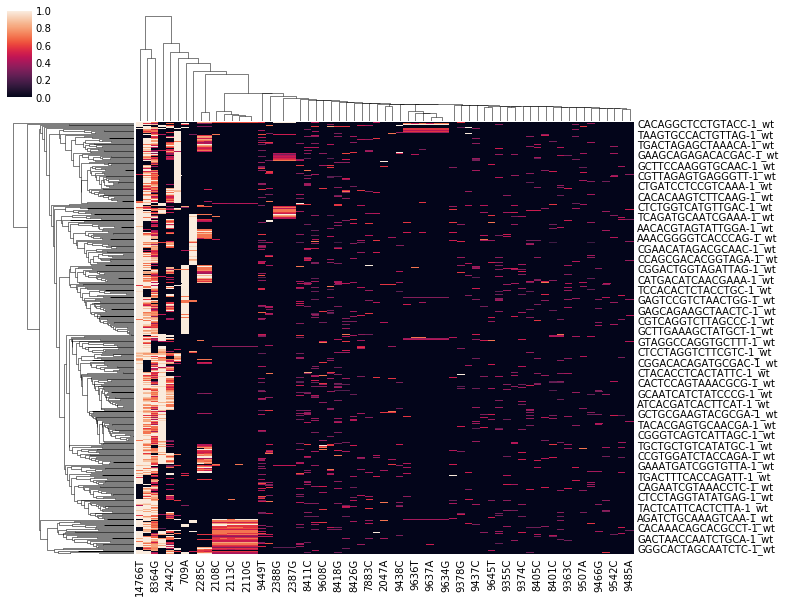

In [27]:
wt_AF_by_cell = wt_AF_by_cell.loc[:,(wt_AF_by_cell>0).any(axis=0)]
sns.clustermap(np.sqrt(wt_AF_by_cell), )